In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import spacy
import pandas as pd   
import requests       
from bs4 import BeautifulSoup 
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics

### The First part will be to collect all the imdb ids of the top 1000 movies.

In [9]:
data = pd.read_csv('movie_DF_output.csv')
data = pd.DataFrame(data)

data.head()

,Unnamed: 0,Name of movie,Genre,Year of relase,Runtime (Minutes),Movie Rating,Metascore,Votes,Description,details
0,0,The Shawshank Redemption,Drama,1994.0,142,9.3,82.0,"2,873,242","Over the course of several years, two convicts...","[0, ['English'], 73, 'Frank Darabont', ""Chroni..."
1,1,The Godfather,"Crime, Drama",1972.0,175,9.2,100.0,"2,001,286",The aging patriarch of an organized crime dyna...,NaN
2,2,The Dark Knight,"Action, Crime, Drama",2008.0,152,9.0,84.0,"2,855,626",When the menace known as the Joker wreaks havo...,"[1, ['English', 'Mandarin'], 243, 'Christopher..."
3,3,Schindler's List,"Biography, Drama, History",1993.0,195,9.0,95.0,"1,443,212","In German-occupied Poland during World War II,...","[0, ['English', 'Hebrew', 'German', 'Polish', ..."
4,4,The Lord of the Rings: The Return of the King,"Action, Adventure, Drama",2003.0,201,9.0,94.0,"1,968,792",Gandalf and Aragorn lead the World of Men agai...,"[1, ['English', 'Quenya', 'Old English', 'Sind..."


# Cleaning the dataset


### We created columns based on information we gathered and stored in the Details column.

In [10]:
import ast
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (ValueError, SyntaxError):
        return []

In [11]:
data["details"] = data["details"].apply(convert_to_list)
data["series"] = data["details"].str.get(0)
data["language"]= data["details"].str.get(1)
data["cast_size"]= data["details"].str.get(2)
data['director']= data["details"].str.get(3)
data['storyline']= data["details"].str.get(4)

### Tokenization: Breaking Down Text into Tokens

In [12]:
def word(text):
    sentences = sent_tokenize(text)
    # Splitting the sentences into words and arranging them by frequency
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    filtered_words = [word for word in words if (word.lower() not in set(stopwords.words('english')))]
    lemmatizer = WordNetLemmatizer()  
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in filtered_words]
    return ' '.join(lemmatized_words)

In [13]:
#Conversion and Processing of Storyline Data
data["storyline"] = data["storyline"].astype(str)
data["storyline"] =data["storyline"].apply(lambda x: word(x))
storyline_list= data["storyline"].tolist()

In [14]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the corpus to get the TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(storyline_list)

# Get feature names (words)
if hasattr(vectorizer, 'get_feature_names_out'):
    feature_names = vectorizer.get_feature_names_out()
else:
    feature_names = vectorizer.get_feature_names()

# Create a DataFrame to store the TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Sum the TF-IDF scores across all documents (rows)
total_tfidf_scores = tfidf_df.sum()

# Get the top 20 words with the highest TF-IDF scores
top_20_words = total_tfidf_scores.nlargest(22)

top_20_words = top_20_words.index.tolist()[2:]

# Creating a Word Count Column Based on Top 20 Words Presence in Storyline
data['word_count'] = data['storyline'].str.lower().str.split().apply(lambda x:  1 if any(word in x for word in top_20_words) else 0)

### Treating remaining columns and missing values

In [15]:
#Removing Commas and Converting Votes to Float 
data["Votes"]=data["Votes"].str.replace(',','')
data['Votes'] = data['Votes'].astype(float)

# Treating missing values in the METASCORE column 
data['Metascore'] = data.groupby(['Votes', 'Movie Rating'])['Metascore'].transform('mean').fillna(method='ffill')

#Data Processing: Dropping 'Unnamed: 0' Column and Removing NaN Values
data= data.drop(columns=['Unnamed: 0'])
data= data.dropna()

#Resetting Index in DataFrame 'df'
df = data.reset_index(drop=True)


In [16]:
#Checking the status of existing columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name of movie      935 non-null    object 
 1   Genre              935 non-null    object 
 2   Year of relase     935 non-null    float64
 3   Runtime (Minutes)  935 non-null    int64  
 4   Movie Rating       935 non-null    float64
 5   Metascore          935 non-null    float64
 6   Votes              935 non-null    float64
 7   Description        935 non-null    object 
 8   details            935 non-null    object 
 9   series             935 non-null    float64
 10  language           935 non-null    object 
 11  cast_size          935 non-null    float64
 12  director           935 non-null    object 
 13  storyline          935 non-null    object 
 14  word_count         935 non-null    int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 109.7+ KB


### Converting 'Year of Release' to Binary Encoding
#### Year 1995 was chosen as a suitable cutoff. Movies released before 1995 became 0 and after 1990 became 1

In [17]:
df['Year of relase'] = pd.to_numeric(df['Year of relase'])
for i in range(len(df)):
    if df['Year of relase'][i]<1995:
        df['Year of relase'][i]=0
    else:
        df['Year of relase'][i]=1
dummy_year=pd.get_dummies(df['Year of relase'])



C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\312676980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year of relase'][i]=0
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\312676980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year of relase'][i]=1
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\312676980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year of relase'][i]=0
C:\Users\lidor\AppData\Lo

###  Runtime (Minutes)

#### Visualization of Film Runtimes Distribution with Mean and Standard Deviation

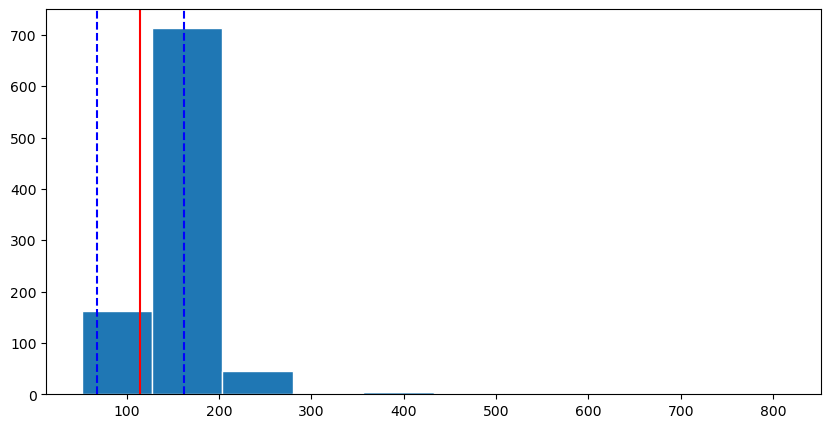

In [18]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.hist(df['Runtime (Minutes)'],edgecolor='white',align='right')
ax.axvline(x=np.mean(df['Runtime (Minutes)']),c='r')
ax.axvline(x=np.mean(df['Runtime (Minutes)'])-np.std(df['Runtime (Minutes)']),c='b',ls='--')
ax.axvline(x=np.mean(df['Runtime (Minutes)'])+np.std(df['Runtime (Minutes)']),c='b',ls='--')
plt.show()

#### Conversion to binary based on the average

In [19]:
df['Runtime (Minutes)']=pd.to_numeric(df['Runtime (Minutes)'],errors='coerce')
x = np.mean(df['Runtime (Minutes)'])
for i in range(len(df)):
    if df['Runtime (Minutes)'][i]<= x:
        df['Runtime (Minutes)'][i]=0
    else: 
        df['Runtime (Minutes)'][i]=1

C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\3564770729.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Runtime (Minutes)'][i]=1
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\3564770729.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Runtime (Minutes)'][i]=1
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\3564770729.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Runtime (Minutes)'][i]=1
C:\Users\lido

### Functions for Data Cleaning, Top-N Analysis, and Plotting

In [20]:
def clean(column_name):

    name=set()
    for name_string in df[column_name]:
        name.update(name_string.split(', '))
    name=sorted(name)
    return name

def top(column_name):

    name=clean(column_name)
    dummy_name=pd.DataFrame()
    for n in name:
        dummy_name[n]=[int(n in nm.split(', ')) for nm in df[column_name]] 
    
    namelist=[n for n in name]
    nlt=dummy_name[namelist].sum()
    nlt=nlt.sort_values(axis=0,ascending=False)
    return nlt.index

def plot_column(column_name,n_elem_display=0):
   
    name=clean(column_name)
    dummy_name=pd.DataFrame()
    for n in name:
        dummy_name[n]=[int(n in nm.split(', ')) for nm in df[column_name]] 
    
    namelist=[n for n in name]
    nlt=dummy_name[namelist].sum()
    nlt=nlt.sort_values(axis=0,ascending=False)
    if n_elem_display !=0:
        return nlt[:n_elem_display].plot(kind = "bar",figsize=(10,10))
    else:
        return nlt[:].plot(kind = "bar",figsize=(10,5))

###  Genre

#### Plotting Genre Distribution

<Axes: >

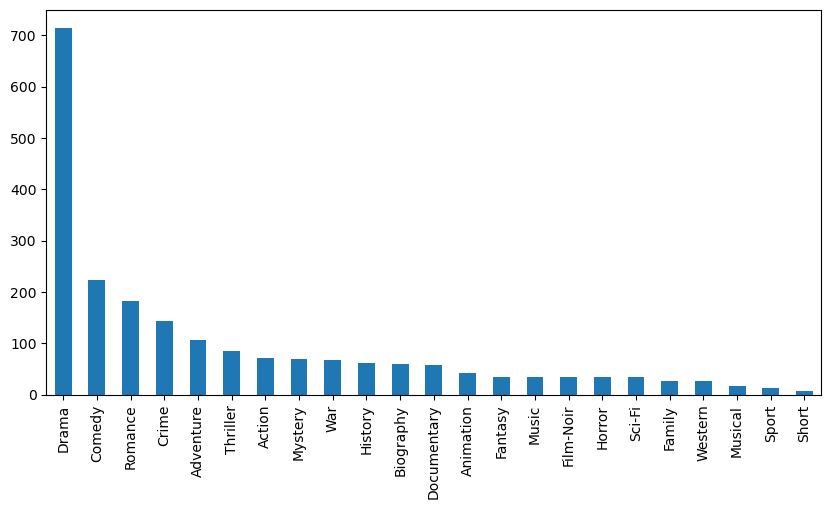

In [21]:
plot_column('Genre')

#### Creating Binary Genre Columns from Multi-word Genre Data

In [22]:
genres = df['Genre'].unique()
single_word_genres = df['Genre'].apply(lambda x: pd.Series(str(x).split(', '))).stack().value_counts()[df['Genre'].apply(lambda x: pd.Series(str(x).split(', '))).stack().value_counts() > 0].index.tolist()
single_word_genres.sort()
for genre in single_word_genres:
    df["genre:"+genre] = [int(genre in g.split(', ')) for g in df['Genre']]

### director

In [23]:
# Counting Directors:
director_count = df['director'].value_counts()

# Calculating Director Ratings
director_ratings = df.groupby('director')['Movie Rating'].mean()

#Identifying Top Directors
top_directors = director_ratings[director_count >= 5].sort_values(ascending=False).head(20)
Top_20_directors = top_directors.index.tolist()

# Creating Binary Columns for Top 20 Directors
for director in Top_20_directors:
    df["Director:"+director] = [int(director in d.split(', ')) for d in df.director] 


###  Language

In [24]:
# Function for each row that converts the list of languages to a string
def convert_to_str(row):
    return ', '.join(row)

# Replacing the 'language' column with a string by applying the function to each row
df['language'] = df['language'].apply(convert_to_str)

#### Top 10 Languages Plot

<Axes: >

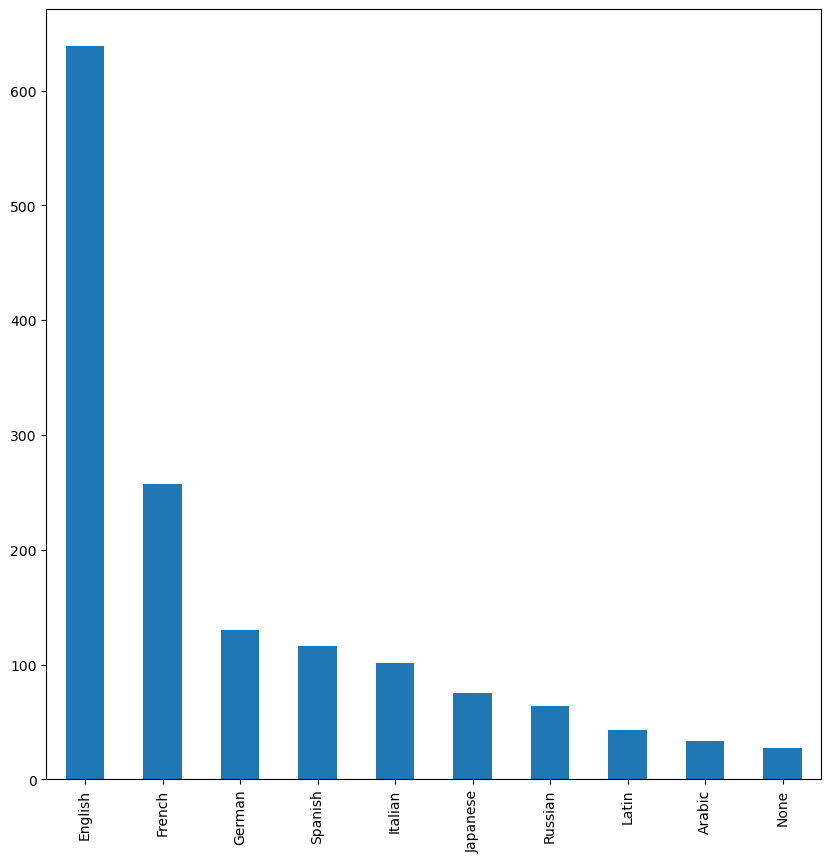

In [25]:
plot_column('language',10)

#### Creating Binary Language Columns for Top Languages

In [26]:
languages = top('language')

for language in languages[:9]:
    df["language:"+language] = [int(language in l.split(', ')) for l in df['language']]

### Metascore , Movie Rating , VOTES , cast_size

#### Conversion to binary based on the average

In [27]:
# METASCORE
df['Metascore'] = pd.to_numeric(df['Metascore'])
x = np.mean(df['Metascore'])
for i in range(len(df)):
    if df['Metascore'][i]<= x:
        df['Metascore'][i]=0
    else: 
        df['Metascore'][i]=1

# Movie Rating
df['Movie Rating'] = pd.to_numeric(df['Movie Rating'])
x = np.mean(df['Movie Rating'])
for i in range(len(df)):
    if df['Movie Rating'][i]<= x:
        df['Movie Rating'][i]=0
    else: 
        df['Movie Rating'][i]=1

# Votes
df['Votes'] = pd.to_numeric(df['Votes'])
x = np.mean(df['Votes'])
for i in range(len(df)):
    if df['Votes'][i]<= x:
        df['Votes'][i]=0
    else: 
        df['Votes'][i]=1

# cast_size
df['cast_size'] = pd.to_numeric(df['cast_size'])
x = np.mean(df['cast_size'])
for i in range(len(df)):
    if df['cast_size'][i]<= x:
        df['cast_size'][i]=0
    else: 
        df['cast_size'][i]=1


C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Metascore'][i]=0
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Metascore'][i]=0
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Metascore'][i]=1
C:\Users\lidor\AppData\Local\Temp\ipy

C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Metascore'][i]=1
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Metascore'][i]=1
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Metascore'][i]=0
C:\Users\lidor\AppData\Local\Temp\ipy

C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie Rating'][i]=0
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie Rating'][i]=0
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie Rating'][i]=0
C:\Users\lidor\AppData\Lo

C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Votes'][i]=0
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Votes'][i]=1
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Votes'][i]=1
C:\Users\lidor\AppData\Local\Temp\ipykernel_11

C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast_size'][i]=1
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast_size'][i]=1
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast_size'][i]=0
C:\Users\lidor\AppData\Local\Temp\

C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast_size'][i]=1
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast_size'][i]=0
C:\Users\lidor\AppData\Local\Temp\ipykernel_11880\1694514987.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast_size'][i]=0
C:\Users\lidor\AppData\Local\Temp\

In [28]:
df.head()

,Name of movie,Genre,Year of relase,Runtime (Minutes),Movie Rating,Metascore,Votes,Description,details,series,...,Director:Jean-Pierre Melville,language:English,language:French,language:German,language:Spanish,language:Italian,language:Japanese,language:Russian,language:Latin,language:Arabic
0,The Shawshank Redemption,Drama,0.0,1,1.0,0.0,1.0,"Over the course of several years, two convicts...","[0, [English], 73, Frank Darabont, Chronicles ...",0.0,...,0,1,0,0,0,0,0,0,0,0
1,The Dark Knight,"Action, Crime, Drama",1.0,1,1.0,0.0,1.0,When the menace known as the Joker wreaks havo...,"[1, [English, Mandarin], 243, Christopher Nola...",1.0,...,0,1,0,0,0,0,0,0,0,0
2,Schindler's List,"Biography, Drama, History",0.0,1,1.0,1.0,1.0,"In German-occupied Poland during World War II,...","[0, [English, Hebrew, German, Polish, Latin], ...",0.0,...,0,1,0,1,0,0,0,0,1,0
3,The Lord of the Rings: The Return of the King,"Action, Adventure, Drama",1.0,1,1.0,1.0,1.0,Gandalf and Aragorn lead the World of Men agai...,"[1, [English, Quenya, Old English, Sindarin], ...",1.0,...,0,1,0,0,0,0,0,0,0,0
4,The Godfather Part II,"Crime, Drama",0.0,1,1.0,1.0,1.0,The early life and career of Vito Corleone in ...,"[1, [English, Italian, Spanish, Latin, Sicilia...",1.0,...,0,1,0,0,1,1,0,0,1,0


# Clustering

#### Since the number of features in the dataset are very high, we first have to perform PCA to reduce it to a suitable number so as to avoid the curse of dimensionality.

In [29]:
df_final2 = df.drop(['Genre','Description','director','details','language','storyline',],axis = 1)

## PCA

#### Before applying the PCA algorithm we have to standardize our features.

In [30]:
df_matrix = df_final2.drop('Name of movie',axis=1)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_matrix)
df_matrix =scaler.transform(df_matrix)

In [31]:
df_matrix

array([[-0.64217342,  1.26096301,  1.08604198, ..., -0.27106966,
        -0.21955928, -0.19127301],
       [ 1.55721175,  1.26096301,  1.08604198, ..., -0.27106966,
        -0.21955928, -0.19127301],
       [-0.64217342,  1.26096301,  1.08604198, ..., -0.27106966,
         4.55457858, -0.19127301],
       ...,
       [ 1.55721175, -0.79304468, -0.92077472, ..., -0.27106966,
        -0.21955928, -0.19127301],
       [ 1.55721175, -0.79304468, -0.92077472, ..., -0.27106966,
        -0.21955928, -0.19127301],
       [-0.64217342, -0.79304468, -0.92077472, ..., -0.27106966,
        -0.21955928, -0.19127301]])

In [32]:
from sklearn.decomposition import PCA
pca = PCA().fit(df_matrix)
top_PCA=["%.2f" % a for a in pca.explained_variance_ratio_ if a >=0.01]
print(len(top_PCA))
print(top_PCA)
sumall=sum(pca.explained_variance_ratio_)

pca48 = PCA(n_components=len(top_PCA)).fit(df_matrix)
sum48=sum(pca48.explained_variance_ratio_)
print (sum48/sumall)

48
['0.05', '0.04', '0.03', '0.03', '0.03', '0.03', '0.03', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01']
0.9089542052418492


### First component explains the highest i.e 5% of variance in our data. We have selected those components which explain 1% or more variation in our dataset. Thus, we endup with 48, and 90.89% variation in our dataset.

# DBSCAN

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

Xpca=pca48.transform(df_matrix)

results =[]

for eps in [0.5,1,2,3,4,5,6,7,8,9,10,11]:
    for min_samples in range(1,10):
        db = DBSCAN(eps=eps, min_samples=min_samples)
        y = db.fit_predict(Xpca)
        if len(set(db.labels_))> 4 and len(set(db.labels_))<935:
            silhouette_avg = silhouette_score(Xpca, db.labels_, metric='euclidean')
            results.append((min_samples, eps, silhouette_avg))
#             print (str(eps) + " " + str(min_samples) + ": "+ str(silhouette_score(Xpca, db.labels_, metric='euclidean')))

best_result = max(results, key=lambda x: x[2])
print("Best result:")
print("Min_samples:", best_result[0])
print("Epsilon:", best_result[1])
print("Silhouette score:", best_result[2])

Best result:
Min_samples: 1
Epsilon: 11
Silhouette score: 0.39366030986715256


In [35]:
from sklearn import metrics
db = DBSCAN(eps=11, min_samples=1).fit(Xpca)


core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
dbscanlabels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbscanlabels)) - (1 if -1 in dbscanlabels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Xpca, dbscanlabels))

Estimated number of clusters: 14
Silhouette Coefficient: 0.394


# Clustering Analysis with Gaussian Mixture Models and BIC Evaluation

C:\Users\lidor\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\lidor\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\lidor\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\lidor\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

Best number of clusters according to BIC: 8


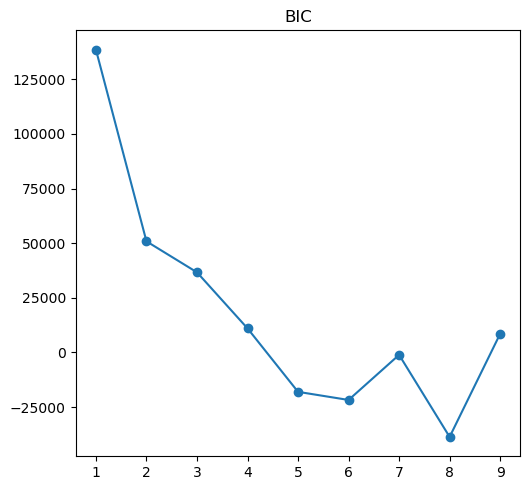

In [110]:
Xpca=pca48.transform(df_matrix)
bic_scores = []
silhouette_scores = []

for n_clusters in range(1,10):
    em = GaussianMixture(n_components=n_clusters)
    em.fit(Xpca)
    bic = em.bic(Xpca)
    
    bic_scores.append(bic)
    labels = em.predict(Xpca)
     
best_bic_scores = bic_scores.index(min(bic_scores)) + 1
print("Best number of clusters according to BIC:",best_bic_scores)
   
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2) 
plt.plot(range(1,10),  bic_scores, marker='o')
plt.title("BIC")

plt.tight_layout()  
plt.show()

### Movie Clustering and Recommendation with Gaussian Mixture Models

In [111]:

X=pca48.transform(df_matrix)


n_clusters = 8  
gmm = GaussianMixture(n_components=8, random_state=42)

gmm.fit(X)

clusters = gmm.predict(X)

def closest_movies(movie_name, cluster_label, k=3):
    movie_index = df_final2.index[df_final2['Name of movie'] == movie_name][0]
    cluster_indices = np.where(clusters == cluster_label)[0]
    cluster_data = X[cluster_indices]
    distances = cdist([X[movie_index]], cluster_data, 'euclidean')[0]
    closest_indices = distances.argsort()[1:k+1]
    closest_movies = df_final2.iloc[cluster_indices[closest_indices]]['Name of movie'].tolist()
    return closest_movies


movie_name = "The Lord of the Rings: The Return of the King"
cluster_label = clusters[df_final2.index[df_final2['Name of movie'] == movie_name][0]]
closest = closest_movies(movie_name, cluster_label)

C:\Users\lidor\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


#### Calculating Similarity Scores Between Movies

In [135]:
movies =closest 
movies.append(movie_name)
vectors = []
for movie_name in movies[:3]:
    vector = df[df['Name of movie'] == movie_name].select_dtypes(include=np.number).values.flatten()
    vectors.append(vector)

last_movie_vector = df[df['Name of movie'] == movie_name].select_dtypes(include=np.number).values.flatten()

similarity_scores = cosine_similarity(vectors, [last_movie_vector])

for i, movie_name in enumerate(movies[0:2]):
    similarity = similarity_scores[i][0]
    print("Similarity between {} and {}: {:.2f}".format(movie_name, movies[-1], similarity))

Similarity between The Lord of the Rings: The Fellowship of the Ring and The Lord of the Rings: The Two Towers: 0.69
Similarity between The Lord of the Rings: The Two Towers and The Lord of the Rings: The Two Towers: 0.61
